In [2]:
!pip3 install -U lazypredict

## Preprocessing 

### Import Libraries

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import math
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import  train_test_split
from lazypredict.Supervised import LazyClassifier



### Configure Properties

In [4]:
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',100)          # Set now of columns visible to 100
pd.set_option('display.max_rows',100)          # Set now of rows visible to 100

In [5]:
df_raw=pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
train=df_raw.copy()
submission=pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
test=pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")


### Inspecting Dataframe

In [6]:
train.shape

(8693, 14)

Column Descriptions : 

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [7]:
# Splitting Passenger id and Cabin  to better understand relation of individual values present in them

train=train.assign(
          PassengerId_GroupId=train['PassengerId'].str[:4].astype(np.int16)
         ,PassengerId_PassengerNumber=train['PassengerId'].str[5:].astype(np.int16)
         )

train.drop(columns='PassengerId',inplace=True)

train=train.assign( 
           Cabin_Deck=train["Cabin"].str.split("/").str[0],
          Cabin_Num=train["Cabin"].str.split("/").str[1],
           Cabin_Side=train["Cabin"].str.split("/").str[2]
         )

train.drop(columns='Cabin',inplace=True)

In [8]:
train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported',
       'PassengerId_GroupId', 'PassengerId_PassengerNumber', 'Cabin_Deck',
       'Cabin_Num', 'Cabin_Side'],
      dtype='object')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   HomePlanet                   8492 non-null   object 
 1   CryoSleep                    8476 non-null   object 
 2   Destination                  8511 non-null   object 
 3   Age                          8514 non-null   float64
 4   VIP                          8490 non-null   object 
 5   RoomService                  8512 non-null   float64
 6   FoodCourt                    8510 non-null   float64
 7   ShoppingMall                 8485 non-null   float64
 8   Spa                          8510 non-null   float64
 9   VRDeck                       8505 non-null   float64
 10  Name                         8493 non-null   object 
 11  Transported                  8693 non-null   bool   
 12  PassengerId_GroupId          8693 non-null   int16  
 13  PassengerId_Passen

### Null Check

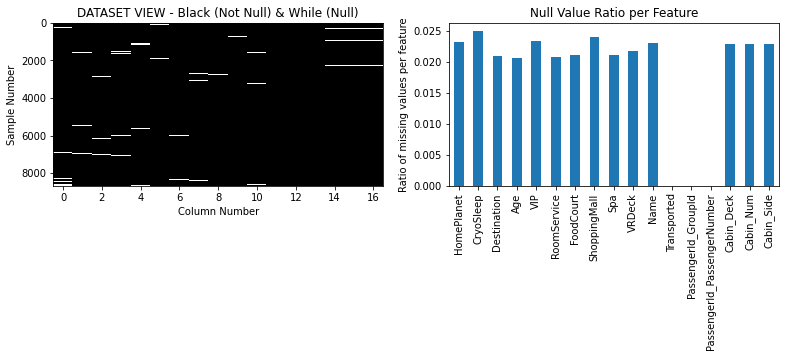

In [10]:
plt.subplots(1,2,figsize=(13,3))
plt.subplot(1,2,1)
plt.imshow(train.isna(), aspect="auto", interpolation="nearest", cmap="gray") # we can test any condition in df using this graph
plt.xlabel("Column Number")
plt.ylabel("Sample Number")
plt.title("DATASET VIEW - Black (Not Null) & While (Null)")
plt.subplot(1,2,2)
train.isna().mean().plot( kind="bar", title="Null Value Ratio per Feature", ylabel="Ratio of missing values per feature")
plt.show()

### Unique Vallue Check

In [11]:
fig = make_subplots(rows=1, cols=2,
                    subplot_titles=("Unique values per Categorical feature", "Unique values per Numerical feature"))


temp_data=train.select_dtypes(exclude="number").nunique().sort_values()

fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)



temp_data=train.select_dtypes(include="number").nunique().sort_values()

fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=2
)

#fig.update_layout(showlegend=False)
fig.show()

In [12]:
train.drop(columns='Name',inplace=True)

In [13]:
#train['PassengerId_PassengerNumber']=train['PassengerId_PassengerNumber'].astype(np.str)

### Value Behaviour

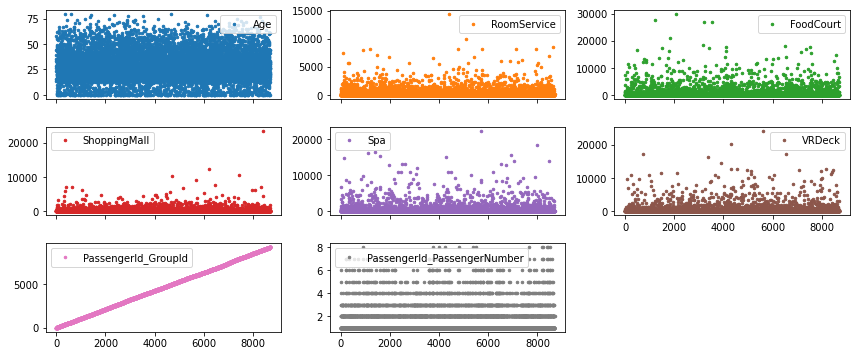

In [14]:
# For all Numerical columnn for all rows 
train.plot(lw=0, marker=".", subplots=True, layout=(-1, 3),
          figsize=(12,5), markersize=5)
plt.tight_layout()

## Univariate Analysis

### Categorical Columns

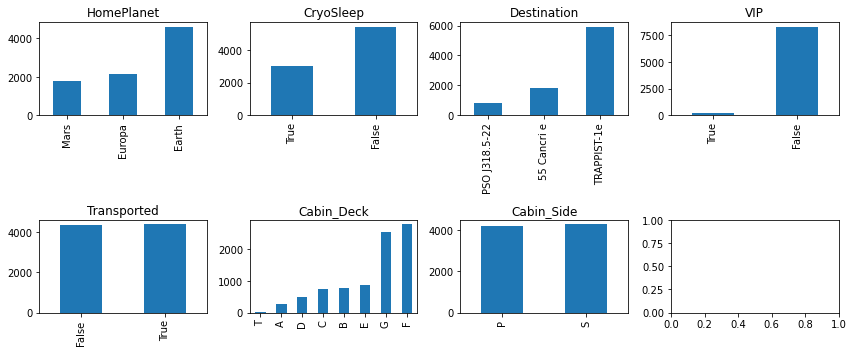

In [15]:
#method 1
# Manually pass column
# fields=['Gender','Exp Type']

#method 2
#For categorical column having distinct categories count <=cat_threshold
cat_threshold=10
fields=train.select_dtypes(exclude="number").nunique()[train.select_dtypes(exclude="number").nunique() <=cat_threshold].index.tolist()

figuresize=(12,5)
cols=4
rows=math.ceil(len(fields)/cols)
#print()

plt.subplots(rows,cols,figsize=figuresize)
for i in range(1,len(fields)+1) :
    plt.subplot(rows,cols,i)
    train[fields[i-1]].value_counts().sort_values().plot.bar()  
    plt.xticks(rotation=90)
    plt.title(fields[i-1])
    
plt.tight_layout()
plt.show()

### Numerical Columns

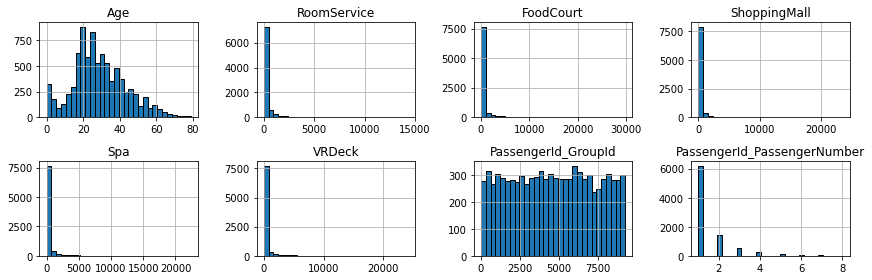

In [16]:
# Plots the histogram for each numerical feature in a separate subplot
figsize_val=(12,4)
layout_val=(-1, 4)
train.hist(bins=30, figsize=figsize_val, layout=layout_val, edgecolor="black")
plt.tight_layout();

In [17]:
kk=(train.select_dtypes(include='number').columns).to_list()

df=train[kk]


upper =df.quantile(0.75)+1.5 *(df.quantile(0.75)-df.quantile(0.25))
lower = df.quantile(0.25)-1.5 *(df.quantile(0.75)-df.quantile(0.25))

for i in train.select_dtypes(include='number'):
    print('\nColumn -> ',i,'')   
    x= df[ (df[i]<round(lower[i],2)) |  (df[i]>round(upper[i],2))][i].to_list()
    print('No of Outliers presesnt -> ',len(x))
    print('\n','*'*10)


Column ->  Age 
No of Outliers presesnt ->  77

 **********

Column ->  RoomService 
No of Outliers presesnt ->  1861

 **********

Column ->  FoodCourt 
No of Outliers presesnt ->  1823

 **********

Column ->  ShoppingMall 
No of Outliers presesnt ->  1829

 **********

Column ->  Spa 
No of Outliers presesnt ->  1788

 **********

Column ->  VRDeck 
No of Outliers presesnt ->  1809

 **********

Column ->  PassengerId_GroupId 
No of Outliers presesnt ->  0

 **********

Column ->  PassengerId_PassengerNumber 
No of Outliers presesnt ->  493

 **********


### Target Variable

In [18]:
train[['Transported']].value_counts(normalize=True).round(decimals=3)*100

Transported
True          50.40
False         49.60
dtype: float64

***
*  50.4 % of training set got transported
*  49.6 % of training set did not got transported
***

## Multivariate Relationship

### Target variable Relation with Categorical variables

In [19]:
train.select_dtypes(exclude='number').columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Transported',
       'Cabin_Deck', 'Cabin_Num', 'Cabin_Side'],
      dtype='object')

In [20]:
# Helping Function
def stats(x):
    temp1=(train[[x,'Transported']].value_counts(normalize=True).round(decimals=3)*100).reset_index().rename(columns={0:'Overall_Percent'})
    Coloumn_To_Aggregate=[x,'Transported']
    df6=pd.merge(train.groupby(Coloumn_To_Aggregate).size().reset_index(name='ind_siz'), 
                 train.groupby(Coloumn_To_Aggregate[:-1]).size().reset_index(name='Total'), on =Coloumn_To_Aggregate[:-1])
    df6['Category_Percent']=round((df6['ind_siz']/df6['Total'])*100 ,2)
    temp2=df6[[x,'Transported','Category_Percent']]
    temp3=temp1.merge(temp2,on=[x,'Transported'])
    return temp3.pivot(columns=x,index='Transported')

#### HomePlanet

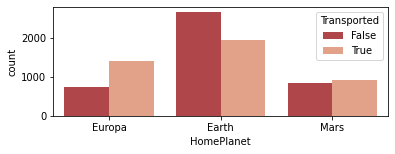

In [21]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['HomePlanet'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.show()

In [22]:
stats('HomePlanet')

Overall_Percent              Category_Percent             
HomePlanet            Earth Europa  Mars            Earth Europa  Mars
Transported                                                           
False                 31.20   8.60  9.90            57.61  34.12 47.70
True                  23.00  16.50 10.80            42.39  65.88 52.30

***
* 49.6 % (Not Transported) -> 31.2 %  were from Earth.
* 50.4 % (Transported)     -> 23 % were from Earth.
***
* 42.39 % of people from earth got transported
* 65.88 % of people from Europa got transported
* 52.3 % of people from Mars got transported
***

#### CryoSleep

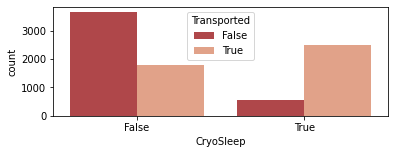

In [23]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['CryoSleep'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.show()

In [24]:
stats('CryoSleep')

Overall_Percent       Category_Percent      
CryoSleep             False  True            False  True
Transported                                             
False                 43.10  6.50            67.11 18.24
True                  21.10 29.30            32.89 81.76

***
* 49.6 % (Not Transported) -> 43.1 %  were not in cryosleep and rest 6.1 % were in sleep.
* 50.4 % (Transported)     -> 29.3 % were in sleep and 21.1 % were not in sleep
***
* 81.6  % of people doing cryosleep got transported
* 18.24 % of people not doing cryosleep got transported
***

#### Destination

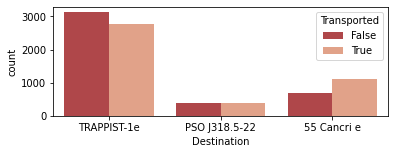

In [25]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['Destination'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.show()

In [26]:
stats('Destination')

Overall_Percent                           Category_Percent  \
Destination     55 Cancri e PSO J318.5-22 TRAPPIST-1e      55 Cancri e   
Transported                                                              
False                  8.20          4.60       36.80            39.00   
True                  12.90          4.70       32.70            61.00   

                                       
Destination PSO J318.5-22 TRAPPIST-1e  
Transported                            
False               49.62       52.88  
True                50.38       47.12

***
* 49.6 % (Not Transported) -> 36.8 %  were going to TRAPPIST-1e
* 50.4 % (Transported)     -> 32.7 %  were going to TRAPPIST-1e
***
* 61.0   % of people going to ''55 Cancri e'' got transported
* 50.38 % of people going to ''PSO J318.5-22'' got transported
* 47.12 % of people going to ''TRAPPIST-1e'' got transported
***

#### VIP

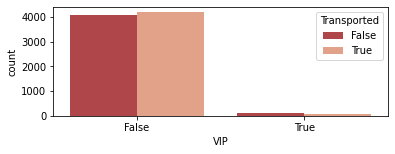

In [27]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['VIP'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.show()

In [28]:
stats('VIP')

Overall_Percent      Category_Percent      
VIP                   False True            False  True
Transported                                            
False                 48.20 1.40            49.37 61.81
True                  49.40 0.90            50.63 38.19

***
* 49.6 % (Not Transported) -> 48.2 %  were not vip
* 50.4 % (Transported)     -> 49.4 %  were not vip
***
* 50.63 % of non vip people got transported
* 38.19 % of vip people got transported
***

#### Cabin_Side

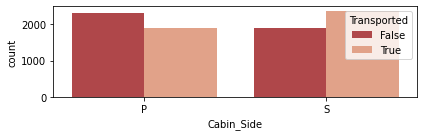

In [29]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['Cabin_Side'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.tight_layout()
plt.show()

In [30]:
stats('Cabin_Side')

Overall_Percent       Category_Percent      
Cabin_Side                P     S                P     S
Transported                                             
False                 27.20 22.50            54.87 44.50
True                  22.30 28.00            45.13 55.50

***
* 49.6 % (Not Transported) -> 27.2 %  were on P side
* 50.4 % (Transported)     -> 28.0 %  were on S side
***
* 45.13 % of people on P side got transported
* 55.5 % of people on S side got transported
***

#### Cabin_Deck

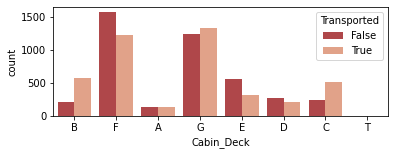

In [31]:
plt.figure(figsize=(6,2))
sns.countplot(x=train['Cabin_Deck'],hue=train['Transported'],palette=sns.color_palette("RdBu"))
plt.show()

In [32]:
stats('Cabin_Deck')

Overall_Percent                                       \
Cabin_Deck                A    B    C    D    E     F     G    T   
Transported                                                        
False                  1.50 2.40 2.80 3.20 6.60 18.40 14.60 0.00   
True                   1.50 6.70 6.00 2.40 3.70 14.50 15.60 0.00   

            Category_Percent                                            
Cabin_Deck                 A     B     C     D     E     F     G     T  
Transported                                                             
False                  50.39 26.57 31.99 56.69 64.27 56.01 48.38 80.00  
True                   49.61 73.43 68.01 43.31 35.73 43.99 51.62 20.00

***
* 49.6 % (Not Transported) -> 18.4 %  were on F desck
* 50.4 % (Transported)     -> 15.6 %  were on G side
***
* 49.61 % of people on A Deck got transported
* 73.43 % of people on B Deck got transported
* 68.01 % of people on C Deck got transported
* 43.31 % of people on D Deck got transported
* 35.73 % of people on E Deck got transported
* 43.99 % of people on F Deck got transported
* 51.62 % of people on G Deck got transported
* 20.0 % of people on T Deck got transported
***

### Target variable Relation with Numerical variables

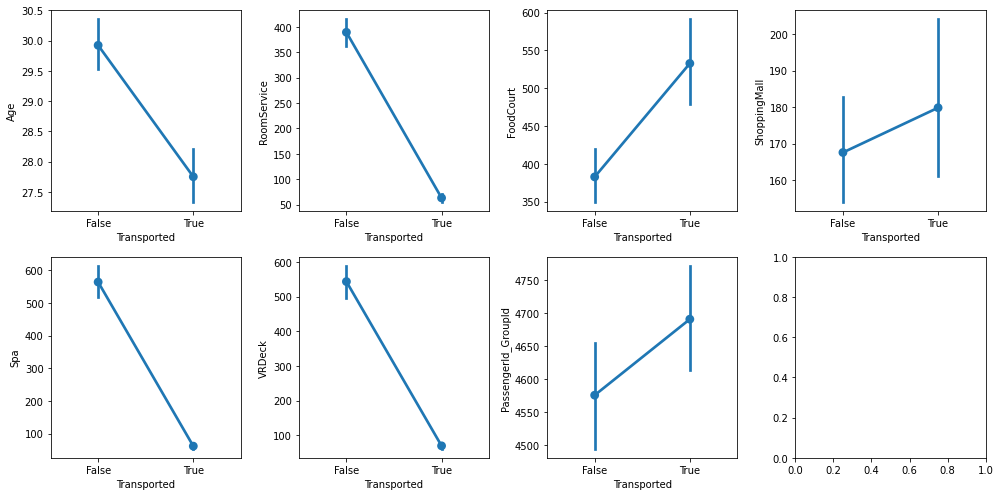

In [33]:
p=train.select_dtypes(include='number').columns.to_list()
p.append("Transported")
y=4
x=math.ceil((len(p)-1)/y)

plt.subplots(x,y,figsize=(14,7))

for i in range(1,len(p)-1) :
    plt.subplot(x,y,i)
    sns.pointplot(data=train[p],y=p[i-1],x='Transported')
    #plt.xlabel(vars[i-1])
    #plt.title(vars[i-1])
plt.tight_layout()    
plt.show()

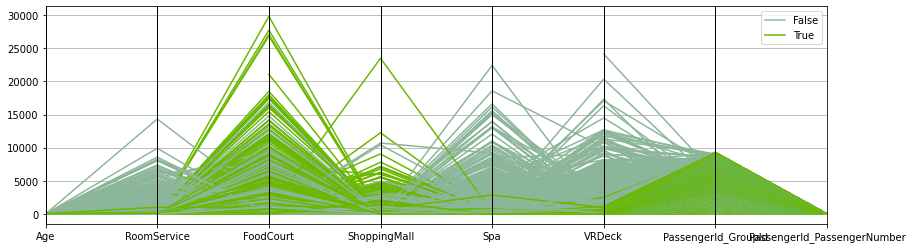

In [34]:
p=train.select_dtypes(include='number').columns.to_list()
p.append("Transported")
#p.remove("PassengerId_GroupId")
#p.remove('Age')
plt.figure(figsize=(14,4)) 
pd.plotting.parallel_coordinates(train[p], "Transported")
plt.show()

***
* Transported person tends to have less bill on spa, vrdeck & room service then the non transported person
* Transported person tends to have more bill on FoodCourt & Shopping Mall then the non transported person
***

### Other Relationships leaving Target variable

In [35]:
fig = px.imshow(df.corr().round(2),zmin=-1,zmax=1, text_auto=True,width=1200,height=650,aspect=None,color_continuous_scale='rdbu')
fig.show()

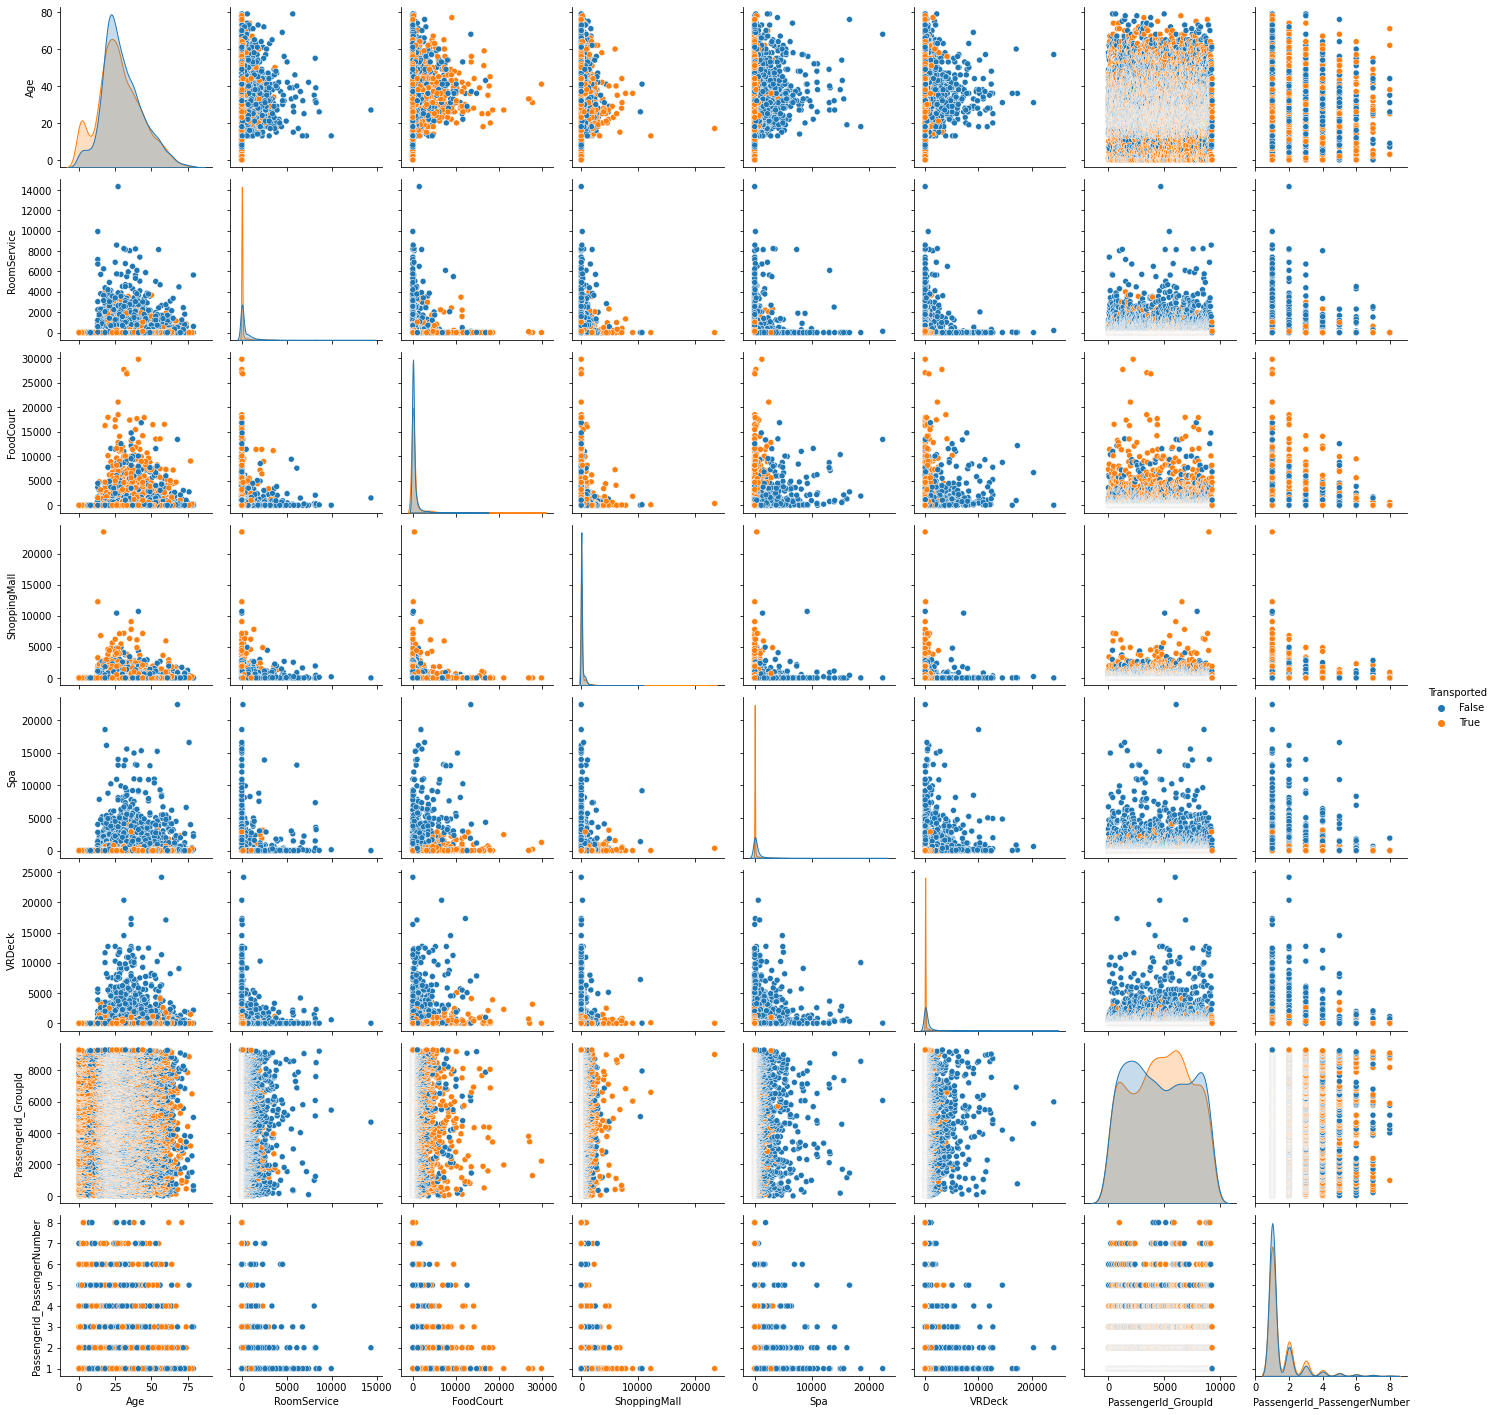

In [36]:
p=train.select_dtypes(include='number').columns.to_list()
p.append("Transported")
sns.pairplot(data=train[p],
                  hue='Transported'
)
                  
plt.show()

***
* No Strong Relationship Observerd among features 
* weak relationship observed among spa, vrdeck and food court
***

## Feature Engineering

### Imputing Null Value 

In [37]:
def ImputeNull(df):
    
    # Home planet 
    mode_HomePlanet = df['HomePlanet'].mode()[0]
    df['HomePlanet'].fillna(mode_HomePlanet)

    # CryoSleep
    mode_CryoSleep = df['CryoSleep'].mode()[0]
    df['CryoSleep'].fillna(mode_CryoSleep)

    # Destination
    mode_Destination = df['Destination'].mode()[0]
    df['Destination'].fillna(mode_Destination)

    # Age
    median_Age = df['Age'].median()
    df['Age'].fillna(median_Age)

    # VIP
    mode_VIP = df['VIP'].mode()
    df['VIP'].fillna(mode_VIP) 
    
    # RoomService
    median_RoomService = df['RoomService'].median()
    df['RoomService'].fillna(median_RoomService)
    
    # FoodCourt
    median_FoodCourt = df['FoodCourt'].median()
    df['FoodCourt'].fillna(median_FoodCourt)
    
    # ShoppingMall
    median_ShoppingMall = df['ShoppingMall'].median()
    df['ShoppingMall'].fillna(median_ShoppingMall)
    
    # Spa
    median_Spa = df['Spa'].median()
    df['Spa'].fillna(median_Spa)
    
    # VRDeck
    median_VRDeck = df['VRDeck'].median()
    df['VRDeck'].fillna(median_VRDeck)
    
    # Cabin_Deck
    mode_Cabin_Deck = df['Cabin_Deck'].mode()
    df['Cabin_Deck'].fillna(mode_Cabin_Deck) 
    
    # VIP
    mode_Cabin_Side = df['Cabin_Side'].mode()
    df['Cabin_Side'].fillna(mode_Cabin_Side) 
    
    return df
    

### Label Encoding

In [38]:
def label_encoder(df):
    columns = ["HomePlanet", "CryoSleep","Cabin_Deck","Cabin_Side", "Destination" ,"VIP"]
    for col in columns:
        df[col] = df[col].astype(str)
        df[col] =  LabelEncoder().fit_transform(df[col])
    return df


In [39]:
def preProcess(df):
    
    df=df.assign(
            PassengerId_GroupId=df['PassengerId'].str[:4].astype(np.int16),
            PassengerId_PassengerNumber=df['PassengerId'].str[5:].astype(np.int16)
         )
    
    df=df.assign( 
           Cabin_Deck=df["Cabin"].str.split("/").str[0],
           Cabin_Num=df["Cabin"].str.split("/").str[1],
           Cabin_Side=df["Cabin"].str.split("/").str[2]
         )
    
    df=df.drop(columns=['PassengerId','Cabin','PassengerId_PassengerNumber','Cabin_Num','Name'])
    
    df=ImputeNull(df)
    
    df=label_encoder(df)
    
    return df

In [41]:
X = df_raw.drop('Transported' , axis =1 )
Y = df_raw['Transported']
X_train , X_test , Y_train , Y_test = train_test_split(X , Y, random_state = 5 ,test_size =0.40)

In [42]:
X_train=preProcess(X_train)
X_test=preProcess(X_test)

## Model

In [44]:
clf = LazyClassifier(verbose=0,
                     ignore_warnings=True,
                     custom_metric=None,
                     predictions=False,
                     random_state=12,
                     classifiers='all')

models, predictions = clf.fit(X_train , X_test , Y_train , Y_test)


100%|██████████| 29/29 [00:13<00:00,  2.16it/s]


In [45]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
LGBMClassifier,0.80,0.80,0.80,0.80,0.19
RandomForestClassifier,0.80,0.80,0.80,0.80,0.89
ExtraTreesClassifier,0.80,0.80,0.80,0.80,0.76
XGBClassifier,0.80,0.80,0.80,0.80,0.83
AdaBoostClassifier,0.79,0.79,0.79,0.79,0.34
SVC,0.79,0.79,0.79,0.79,1.63
NuSVC,0.79,0.79,0.79,0.79,1.97
CalibratedClassifierCV,0.79,0.79,0.79,0.79,1.77
LogisticRegression,0.79,0.79,0.79,0.79,0.05


In [47]:
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier( random_state=5)
lgbm.fit(X_train, Y_train)
y_pred = lgbm.predict(X_test)

CPU times: user 1.07 s, sys: 10.6 ms, total: 1.08 s
Wall time: 308 ms


## Prediction

In [51]:
test=preProcess(test)
y_pred = lgbm.predict(test)

In [53]:
submission['Transported'] = y_pred.astype("bool")
submission.to_csv("submission.csv",index=False)
submission.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
